# scorEpochs demo
This colab notebook shows the usage of the scorEpochs tool, which is able to provide automatic scoring of resting-state M/EEG epochs, representing an objective (or, at least, a less subjective) method to aid M/EEG experts during epoch selection procedure in resting state's analysis.

<br><br>

It provides a score for each epoch within a single M/EEG recording, taking as input a set of M/EEG recordings and the wished parameters (such as the length of each epoch and the interested frequency band).

The algorithm implemented in scorEpochs can be summarized into 5 steps:
- For each subject, each epoch, and each channel, the algorithm computes the **power spectral density** (**PSD**) via the [**Welch method**](https://en.wikipedia.org/wiki/Welch%27s_method) into the specified range of frequencies 
- At channel-level, a **similarity score**, computed by using the [**Spearman correlation coefficient**](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), is evaluated between the PSD extracted from all the epochs, thus providing a correlation matrix with _N x N_ as dimension, where _N_ is the number of epochs 
- A first average is now computed over the rows (or, equivalently, over the columns) of the symmetric matrix to obtain a score vector with length equal to the number of epochs, where the entries represent the **mean similarity score** of the corresponding epoch
- Computing the score vector for each channel, and then averaging the score vectors across channels, it is possible to obtain a **final score** for each epoch
- Finally, for each subject, the score can be **sorted in descending order** allowing to select the suggested epochs to be included in the subsequent steps of the analysis

<br><br>

It is freely downloadable from its [github repository](https://github.com/Scorepochs-tools/scorepochs_py).

## Initial settings
Before the actual demonstration, it is necessary to clone the tool, to install the mne library, and finlly to download the EEG record.

In order to clone a github repository in colab, it is possible to issue the command **!git clone _repository_url_**.

In [1]:
!git clone https://github.com/Scorepochs-tools/scorepochs_py.git

Cloning into 'scorepochs_py'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


Now, we need to install the mne library in order to read data from the edf file which we will use for the demonstration.

This open-source Python package allows to explore, visualize and analyze human neurophysiological data, such as EEGs and MEGs.

In [2]:
!pip install mne

     |████████████████████████████████| 7.4 MB 5.7 MB/s 


In order to download a file, knowing the related URL, it is possible to use wget, which allows to retrieve files via HTTP or FTP.

The file belongs to the dataset available at https://physionet.org/content/eegmmidb/1.0.0/, and represents a 64-channels EEG recording, related to a subject in resting stata, with eyes open.

In [15]:
!wget https://physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf

--2022-02-16 19:04:12--  https://physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1275936 (1.2M) [application/octet-stream]
Saving to: ‘S001R01.edf.1’

S001R01.edf.1       100%[===================>]   1.22M  3.30MB/s    in 0.4s    

2022-02-16 19:04:13 (3.30 MB/s) - ‘S001R01.edf.1’ saved [1275936/1275936]



## Raw data analysis
Here, we extract data from the file, and then we analyze the related properties, such as the sampling frequency and the channels.

Through the mne library, it is possible to read an edf file through the **read_raw_edf** function.

Note that this function returns a Python object, containing the raw data as well as the related recording information.

So, in order to obtain the raw data from it, we can use the **get_data** method.

In [16]:
import mne
import numpy as np

file = "S001R01.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()

Extracting EDF parameters from /content/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Now, we can analyze the retrieved data, such as the number of channels and their names, and the sampling frequency.

In particular, the scorEpochs tool requires the sampling frequency (_sfreq_) among the other parameters.

Another useful information is the total number of samples, in order to obtain the total number of seconds related to the EEG signal.

In [17]:
print(data.info)
print('\n Dimensions: ' + str(np.shape(raw_data)) + '\n')
print(data.ch_names)

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

 Dimensions: (64, 9760)

['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


Since this 64-channel EEG is composed of 9760 samples, with a sampling frequency equal to 160 Hz, then it is related to a 61 seconds of recording (9760/160 = 61).

## Find the best epochs
Finally, we can use the scorEpochs tool in order to obtain the best epochs. 

The scorEpochs function requires the raw data matrix, having _channels x samples_ dimensions, and one dictionary _cfg_, having the following key-value pairs:
 - **freqRange**: a 2-elements list related to the analyzed frequency band (i.e. the lower cut frequency and the higher one, in Hz)
 - **fs**: the sampling frequency (in Hz)
 - **windowL**: the number of seconds of each epoch (the epochs will be non-overlapped)
 - **smoothFactor**: smoothing factor for the power spectrum (optional)

Then, the output of the function are:
 - **idx_best_ep**: list of indexes sorted according to the best score (this list should be used for the selection of the best epochs)
 - **epoch**: 3D list of the data divided in equal length epochs of length _windowL_, having dimensions _channels X epochs X samples_
 - **score_Xep**: array containing the score of each epoch

For example, we can analyze the frequency band between 1 and 40 Hz, and subdivide the overall time series into 3 seconds-epochs, for a total of 20 epochs (the first epoch between 0 and 3 seconds, the second epoch between 3 and 6 seconds, and so on).

In [18]:
from scorepochs_py.scorepochs import *

t_ep = 3
fs = 160
freq = [1, 40]

cfg = {'freqRange':freq, 'fs':fs, 'windowL':t_ep}

idx_best, epoch, scores = scorEpochs(cfg, raw_data)

Epoch will have **n_epochs x n_channels x n_samples** as dimension.

Since _idx_best_ provides the indexes of the epochs sorted in descending order with respect to the similarity score, we can obtain the score of the "best" epoch as _scores[idx_best[0]]_, while the score of the "worst" epoch as _scores[idx_best[-1]]_.

In [19]:
print('Scores:\n - Best epoch:  ' + str(scores[idx_best[0]]) + '\n - Worst epoch: ' + str(scores[idx_best[-1]]))

Scores:
 - Best epoch:  0.954545036764706
 - Worst epoch: 0.929324448529412


Equivalently, we could obtain the "best" epoch and the "worst" one as _epoch[idx_best[0]]_ and _epoch[idx_best[-1]]_, respectively.

Here, we shows those epochs as example, representing only some channels for visibility issues.

Best epoch:


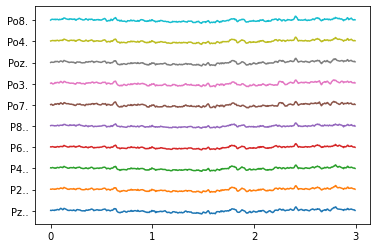

Worst epoch:


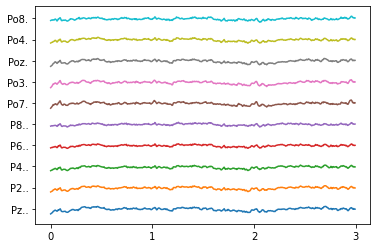

In [20]:
import matplotlib.pyplot as plt

delta = abs(np.squeeze(epoch[idx_best[0], :, :])).max()*2
n = 10
ch_start = 50
samples = t_ep*fs

print('Best epoch:')
for i in range(n):
  plt.plot(epoch[idx_best[0], i+ch_start, :]+delta*i*2)
plt.yticks(range(n)*delta*2, data.ch_names[ch_start:ch_start+n])
plt.xticks(range(0, samples+1, fs), range(t_ep+1))
plt.show()

print('Worst epoch:')
for i in range(n):
  plt.plot(epoch[idx_best[-1], i+ch_start, :]+delta*i*2)
plt.yticks(range(n)*delta*2, data.ch_names[ch_start:ch_start+n])
plt.xticks(range(0, samples+1, fs), range(t_ep+1))
plt.show()